In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import pandas as pd  
import warnings  
import matplotlib.pyplot as plt  
import seaborn as sns 
import numpy as np
import matplotlib


import draw_function
from scipy.spatial import ConvexHull

myfont = matplotlib.font_manager.FontProperties(fname="/System/Library/fonts/PingFang.ttc")
sns.set(font=myfont.get_name())
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


from dispatch_utils import get_dispatch_df
from plot_resrurant_utils import process_most_orders_per_restaurant, process_station_data, draw_map
from resturant_feature_utils import get_resturuant_feature_df

# 划分日期

In [33]:
start_date = '2024-04-24'
end_date = '2024-04-30'
order_dispatch_path = f'./data/dispatchlog_{start_date}_{end_date}.csv'
order_34_path = f'./data/34_{start_date}_{end_date}.csv'

# df3 = pd.read_excel('./data/3_1.xlsx',  engine='openpyxl')
# df4 = pd.read_excel('./data/4_1.xlsx',  engine='openpyxl')
# df4.columns = df3.columns  
# data2 = pd.concat([df3, df4], axis=0)
data2 = pd.read_excel('./data/223.xlsx')
data2.to_csv(order_34_path, index = False)
# data2.columns
# data2.shape[0]
df = get_dispatch_df(data2, start_date, end_date)
df.to_csv(order_dispatch_path, index = False)

1、日期处理完毕
2、类型处理完毕
3、时间间隔处理完毕
4、分配标记隔处理完毕
存储路径 ./data/dispatchlog_2024-04-24_2024-04-30.csv


In [34]:
# df1 = pd.read_excel('./data/1_1.xlsx', engine='openpyxl')
# df2 = pd.read_excel('./data/2_1.xlsx', engine='openpyxl')
# df2.columns = df1.columns  
# data = pd.concat([df1, df2], axis=0)
data = pd.read_excel('./data/111.xlsx')
order_12_path = f'./data/12_{start_date}_{end_date}.csv'
data.to_csv(order_12_path, index = False)
data = data[(data['下单时间'] >= start_date) & (data['下单时间'] <= end_date)]

# 生成餐厅信息文件

In [35]:
use_cols = ['餐厅编号', '餐厅经度', '餐厅纬度']
resturuant = data[use_cols].drop_duplicates(subset=use_cols)
resturuant = resturuant.reset_index()
resturuant.rename(columns={'index': '简化编号'}, inplace=True)
resturuant_map = resturuant.set_index('餐厅编号')['简化编号'].to_dict()
data['简化餐厅编号'] = data['餐厅编号'].map(resturuant_map)
resturuant.columns = ['simple_id', 'id', 'longitude', 'latitude']
print('存储路径', './data/resturuant.csv')
resturuant.to_csv('./data/resturuant.csv', index = False)

data.drop(columns=['餐厅编号', '餐厅经度', '餐厅纬度'], inplace=True)

存储路径 ./data/resturuant.csv


In [36]:
order_simple_file_path = f'./data/simple_{start_date}_{end_date}.csv'
data.to_csv(order_simple_file_path, index = False)
restaurant_file_path = './data/resturuant.csv'

merged_df = get_resturuant_feature_df(order_simple_file_path, restaurant_file_path)   
merged_df.drop(['简化餐厅编号'], axis=1, inplace=True)
merged_df.to_excel('./data/restaurant_features_2.xlsx', index = False)

filtered_data_combined = process_most_orders_per_restaurant(order_simple_file_path)
print("每个餐厅编号中订单数量最多的数据处理完成")
all_station_data = process_station_data(filtered_data_combined, merged_df)
draw_map(all_station_data, merged_df)

每个餐厅编号中订单数量最多的数据处理完成
保存成功: ./data/resturan_station_10050.html
保存成功: ./data/resturan_station_10051.html
保存成功: ./data/resturan_station_10055.html
保存成功: ./data/resturan_station_10032.html
保存成功: ./data/resturan_station_10033.html
保存成功: ./data/resturan_station_10034.html
保存成功: ./data/resturan_station_10035.html
保存成功: ./data/resturan_station_10038.html


In [37]:
df = pd.read_csv(order_dispatch_path)
df['分配标记中文'] = np.where(df['分配标记'].isin([1, 2, 12, 22]), df['分配标记'], '其他')
df['分配标记中文'] = df['分配标记中文'].replace({'1': '机器', '2': '人工', '12':'机器_人工', '22':'人工_人工'})
k = df.merge(data)
merged_df.rename(columns = {'simple_id':'简化餐厅编号'}, inplace = True)
df = k.merge(merged_df)

In [38]:
class_counts = df.groupby('简化餐厅编号').size().reset_index(name='数量')
class_gender_counts = df.groupby(['简化餐厅编号', '最终类型']).size().unstack(fill_value=0)
class_gender_counts = class_gender_counts.reset_index()
class_gender_counts['总数量'] = class_gender_counts.sum(axis=1) - class_gender_counts['简化餐厅编号']
class_gender_counts['机器占比'] = (class_gender_counts['机器'] / class_gender_counts['总数量']) * 100
class_gender_counts.reset_index(inplace=True)
final_df_2 = pd.merge(class_gender_counts[['简化餐厅编号', '机器', '总数量', '机器占比']], 
                    class_counts, on='简化餐厅编号')
final_df_2['机器占比'] = final_df_2['机器占比'].apply(lambda x: f"{x:.2f}%")  # 保留两位小数并添加百分号
final_df_2.drop(columns=['数量'], inplace = True)
final_df_2.columns = ['简化餐厅编号', '机器', '总派单次数', '机器派单占比']

class_gender_counts = df.groupby('简化餐厅编号')[['派单数量_人工分配', '派单数量_自动分配']].sum()
class_gender_counts = class_gender_counts.reset_index()
class_gender_counts['总派单次数'] = class_gender_counts['派单数量_人工分配'] + class_gender_counts['派单数量_自动分配']
final_df_3 = class_gender_counts
final_df_3.columns = ['简化餐厅编号', '人工分配总数', '机器分配总数', '总分配次数']


df = df.merge(final_df_2).merge(final_df_3)
df['拒单比'] = round(100 * (df['总分配次数'] - df['总派单次数']) / df['总分配次数'], 2)


file_path = './data/1.txt'
with open(file_path, 'r') as file:
    order_numbers = [int(line.strip()) for line in file if line.strip().isdigit()]

df_orders = pd.DataFrame(order_numbers, columns=['订单编号'])
df_orders['订单编号'].astype(int)
df_orders['订单编号'] = pd.to_numeric(df_orders['订单编号'], errors='coerce')
df_orders['订单编号2'] = df_orders['订单编号'].astype('Int64')
df = df.merge(df_orders,  how='left')
df['join_success'] = np.where(df['订单编号2'].isnull(), 0, 1)
df.drop(columns = ['订单编号2'], inplace = True)
new_column_names = {'join_success': '人工派单标记'}
df.rename(columns=new_column_names, inplace=True)

0        1782816860681740288
1        1782817233765081088
2        1782817305031786496
3        1782817390380392448
4        1782817514659954688
                ...         
19252    1785351758860529664
19253    1785352370648104960
19254    1785352690012295168
19255    1785352771234652160
19256    1785353414310375424
Name: 订单编号, Length: 19257, dtype: int64

In [39]:
r = pd.read_csv(f'./data/12_{start_date}_{end_date}.csv')
r = r[['订单编号', '餐厅经度', '餐厅纬度', '用户收货经度', '用户收货纬度', '许诺用户送达时间']].drop_duplicates()
df = df.merge(r)

In [40]:
cols = ['站点', '订单编号', '城市']
wb_station_city = pd.read_csv(order_12_path)[cols]

,站点,订单编号,城市
0,10035,1782816772628856832,SHV
1,10033,1782816833443213312,PNH
2,10035,1782816853366157312,SHV
3,10033,1782816860681740288,PNH
4,10033,1782816894394839040,PNH


# 生成最终总订单信息表

In [41]:
df = df.merge(wb_station_city)

df['开始调度'] = pd.to_datetime(df['开始调度'])
df['到达'] = pd.to_datetime(df['到达'])
df['开始调度-到达'] = (df['到达'] - df['开始调度']).dt.total_seconds().astype(int)
df.to_csv('./data/alllog_demo1.csv', index=False)


In [42]:
file_name = './data/alllog_demo1.csv'
df = pd.read_csv(file_name)

# 1、概述分析

In [43]:
from IPython.display import HTML
city_counts = df['城市'].value_counts().reset_index()
city_counts.columns = ['城市', '总单量']

machine_counts = df[df['人工派单标记'] == 0]['城市'].value_counts().reset_index()
machine_counts.columns = ['城市', '机器可派单量']

city_cnt_machine = machine_counts.merge(city_counts)
city_cnt_machine['城市机器派单占比'] = round(100 * (city_cnt_machine['机器可派单量'] /  city_cnt_machine['总单量']) , 2)

machine_sum = city_cnt_machine['机器可派单量'].sum()
wb_sum = city_cnt_machine['总单量'].sum()
city_cnt_machine['总单量占比'] = round(100 * city_cnt_machine['总单量'] / city_cnt_machine['总单量'].sum() ,2 )


new_row = {'城市': '总计', 
           '机器可派单量':machine_sum,  
           '总单量':wb_sum, 
           '城市机器派单占比':round(100 * machine_sum/wb_sum, 2),
           '总单量占比':100
          }
 
city_cnt_machine = city_cnt_machine.append(new_row, ignore_index=True)
city_cnt_machine.head(10)

,城市,机器可派单量,总单量,城市机器派单占比,总单量占比
0,PNH,129571,144721,89.53,85.56
1,SHV,11026,11667,94.51,6.90
2,S03,10165,10397,97.77,6.15
3,BTB,1698,1768,96.04,1.05
4,KAM,583,600,97.17,0.35
5,总计,153043,169153,90.48,100.00


# 2、PNH站点维度

In [44]:
df = df[df['城市'] == 'PNH']
city_counts = df['站点'].value_counts().reset_index()
city_counts.columns = ['站点', '总单量']

machine_counts = df[df['人工派单标记'] == 0]['站点'].value_counts().reset_index()
machine_counts.columns = ['站点', '机器可派单量']

city_cnt_machine = machine_counts.merge(city_counts)
city_cnt_machine['站点机器派单占比'] = round(100 * (city_cnt_machine['机器可派单量'] /  city_cnt_machine['总单量']) , 2)
machine_sum = city_cnt_machine['机器可派单量'].sum()
wb_sum = city_cnt_machine['总单量'].sum()
city_cnt_machine['总单量占比'] = round(100 * city_cnt_machine['总单量'] / city_cnt_machine['总单量'].sum() ,2 )

new_row = {'站点': '总计', 
           '机器可派单量':machine_sum,  
           '总单量':wb_sum, 
           '站点机器派单占比':round(100 * machine_sum/wb_sum, 2),
           '总单量占比':100
          }
city_cnt_machine = city_cnt_machine.append(new_row, ignore_index=True)
city_cnt_machine.head()

,站点,机器可派单量,总单量,站点机器派单占比,总单量占比
0,10032,55932,64225,87.09,44.38
1,10033,53720,59525,90.25,41.13
2,10034,19917,20944,95.10,14.47
3,10051,2,27,7.41,0.02
4,总计,129571,144721,89.53,100.00


# 3、时间分桶开发

In [14]:
station_ids = [10032, 10033, 10034]
df = df[df['站点'].isin(station_ids)]


df['下单时间15分钟桶'] = pd.to_datetime(df['下单'])  # 确保列是datetime类型
df['下单时间15分钟桶'] = df['下单时间15分钟桶'].dt.floor('15T')
df['下单时间15分钟桶'] = df['下单时间15分钟桶'].dt.time.apply(lambda x: x.strftime('%H:%M'))
df_plot = df[['站点', '下单时间15分钟桶']]

dates = pd.date_range(start='00:00', periods=96, freq='15T')
time_interval = pd.DataFrame({'下单时间15分钟桶': dates.time})
time_interval['下单时间15分钟桶'] = time_interval['下单时间15分钟桶'].apply(lambda x: x.strftime('%H:%M'))


empty_df = pd.DataFrame(columns=['下单时间15分钟桶'])
for station_id in station_ids:
    empty_df1 = time_interval.copy()
    empty_df1['站点'] = station_id
    empty_df = pd.concat([empty_df, empty_df1], ignore_index=True)

empty_df['站点'] = empty_df['站点'].round().astype(int)
empty_df['key'] = empty_df['下单时间15分钟桶'].astype(str) + '_' + empty_df['站点'].astype(str)

# 4、进单量曲线(按照下单时间进行计算)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='下单时间15分钟桶', ylabel='单量'>

Text(0.5, 0, '15分钟桶(下单时间)')

Text(0, 0.5, '单量')

([<matplotlib.axis.XTick at 0x13aa2b7d0>,
 [Text(0, 0, '00:00'),
  Text(24, 0, '06:00'),
  Text(48, 0, '12:00'),
  Text(72, 0, '18:00')])

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(0, -500.0, '−500'),
  Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500')])

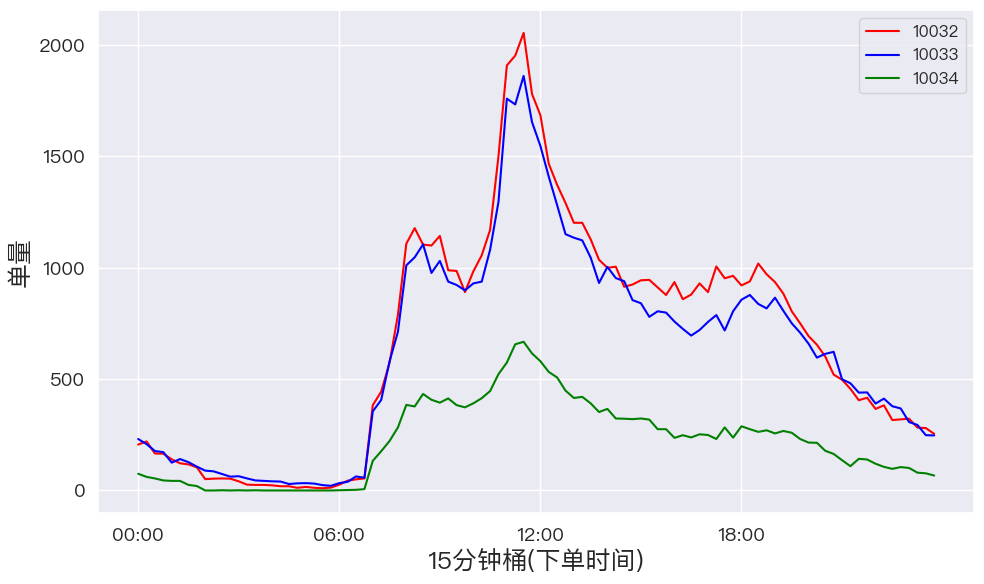

In [15]:
myfont = matplotlib.font_manager.FontProperties(fname="/System/Library/fonts/PingFang.ttc")
sns.set(font=myfont.get_name())

df_plot = df[['站点', '下单时间15分钟桶']]
df_plot = df_plot.groupby(['站点', '下单时间15分钟桶']).size().reset_index()
df_plot.rename(columns = {0:'单量'} , inplace=True)
df_plot['key'] = df_plot['下单时间15分钟桶'].astype(str) + '_' + df_plot['站点'].astype(str)

merged_df = pd.merge(empty_df, df_plot, on='key', how='left')
merged_df.fillna(0, inplace=True)

columns_to_keep = [merged_df.columns[0], merged_df.columns[1], merged_df.columns[5]]  
merged_df = merged_df[columns_to_keep]

merged_df.rename(columns=lambda x: x.replace('_x', ''), inplace=True)
merged_df['单量'] = merged_df['单量'].round().astype(int)


merged_df.to_csv('./data/PNH 15分钟进单量曲线.csv' , index =False)
plt.figure(figsize=(10, 6))  # 设置图形大小
sns.lineplot(x='下单时间15分钟桶', y='单量', hue='站点', data=merged_df, palette=['red', 'blue', 'green'])
full_index = pd.date_range('00:00', '23:45', freq='15T').strftime('%H:%M').to_list()
plt.xlabel('15分钟桶(下单时间)', fontsize = 18)
plt.ylabel('单量',fontsize = 18)
plt.legend(fontsize=12)
plt.xticks(range(0, len(full_index)-1, 24), full_index[::24], fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.grid(True)    

## 5、配送距离(按照下单时间进行计算)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='下单时间15分钟桶', ylabel='配送距离'>

Text(0.5, 0, '15分钟桶(下单时间)')

Text(0, 0.5, '单量')

([<matplotlib.axis.XTick at 0x1463f9590>,
 [Text(0, 0, '00:00'),
  Text(24, 0, '06:00'),
  Text(48, 0, '12:00'),
  Text(72, 0, '18:00')])

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]),
 [Text(0, -2000.0, '−2000'),
  Text(0, 0.0, '0'),
  Text(0, 2000.0, '2000'),
  Text(0, 4000.0, '4000'),
  Text(0, 6000.0, '6000'),
  Text(0, 8000.0, '8000'),
  Text(0, 10000.0, '10000'),
  Text(0, 12000.0, '12000'),
  Text(0, 14000.0, '14000')])

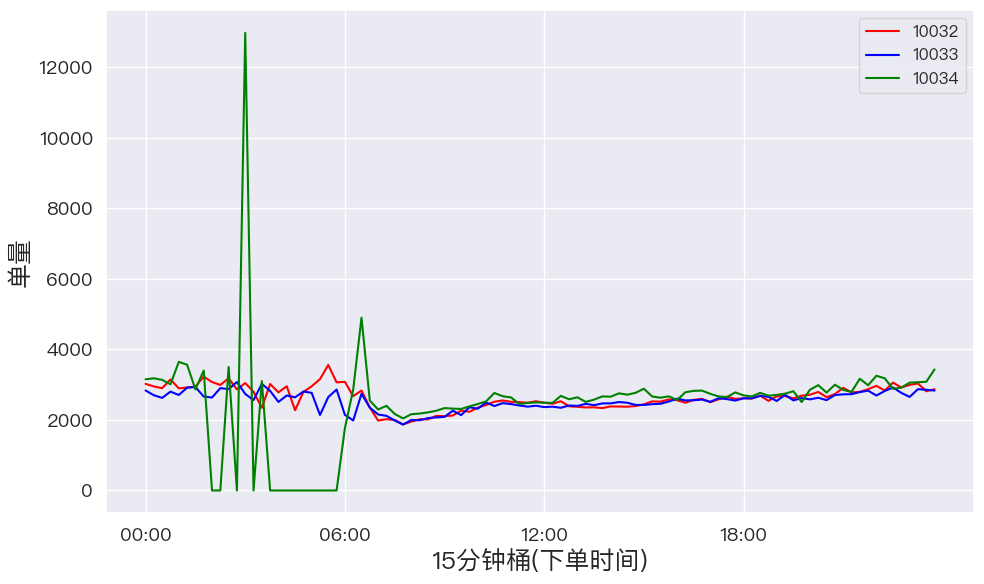

In [16]:
T = 60
s_t = '00:00'
e_t = '23:00'

df_plot = df[['站点', '下单时间15分钟桶', '配送距离']]
df.to_csv('11.csv')
df_plot = df_plot.groupby(['站点', '下单时间15分钟桶'])['配送距离'].mean().reset_index()
df_plot.rename(columns = {0:'配送距离'} , inplace=True)
df_plot['key'] = df_plot['下单时间15分钟桶'].astype(str) + '_' + df_plot['站点'].astype(str)

merged_df = pd.merge(empty_df, df_plot, on='key', how='left')
merged_df.fillna(0, inplace=True)

columns_to_keep = [merged_df.columns[0], merged_df.columns[1], merged_df.columns[5]]  
merged_df = merged_df[columns_to_keep]

merged_df.rename(columns=lambda x: x.replace('_x', ''), inplace=True)
merged_df['配送距离'] = merged_df['配送距离'].round().astype(int)

plt.figure(figsize=(10, 6))  # 设置图形大小
sns.lineplot(x='下单时间15分钟桶', y='配送距离', hue='站点', data=merged_df, palette=['red', 'blue', 'green'])
full_index = pd.date_range('00:00', '23:45', freq='15T').strftime('%H:%M').to_list()
plt.xlabel('15分钟桶(下单时间)', fontsize = 18)
plt.ylabel('单量',fontsize = 18)
plt.legend(fontsize=12)
plt.xticks(range(0, len(full_index)-1, 24), full_index[::24], fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.grid(True)    

## 6、任务过程

In [17]:
df['最小派单']= pd.to_datetime(df['最小派单'])
df['开始调度'] = pd.to_datetime(df['开始调度'])
df['开始调度-最小派单'] = (df['最小派单'] - df['开始调度']).dt.total_seconds()

df['到达']= pd.to_datetime(df['到达'])
df['开始调度-到达'] = (df['到达'] - df['开始调度']).dt.total_seconds()

df['派单类别'] = df.apply(lambda row: str(row['人工派单标记']) + '_' + str(row['最终类型']), axis=1)

In [18]:
cols = ['开小派单-开始调度', '派单-接单', '接单-到店', '到店-取餐', '取餐-到达', '最大派单-最小派单','开始调度-到达', '配送距离']
cols2 = cols[:-1]


max_limit = 120 
df = df[df[cols2].le(max_limit * 60).all(axis=1)]
for stationid in station_ids:
    for r in set(df['派单类别']):
        df_r = df[(df['派单类别'] == r) & (df['站点'] == stationid)]
        r0 = '机器可派单' if r.split('_')[0] == '0' else '机器不可派单'
        r1 = r.split('_')[1]
        
        print('站点',stationid,
              '类别:',r0, 
              '最终派单类别:',r1,
              '订单数量:',df_r.shape[0], 
              '单量占比:',round(100 * df_r.shape[0] / (df[df['站点'] == stationid]).shape[0], 2), '%')
        quantiles = np.array([i * 10 for i in range(1, 11)])
        quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
        quantile_df = quantile_df.T
        quantile_df.head(10)

    df_r = df[(df['人工派单标记'] == 0) & (df['站点'] == stationid)]  
    print('站点',stationid, 
          '机器可派单订单数量', df_r.shape[0], 
          '单量占比', round(100 * df_r.shape[0] / (df[df['站点'] == stationid]).shape[0], 2), '%')
    quantiles = np.array([i * 10 for i in range(1, 11)])
    quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
    quantile_df = quantile_df.T
    quantile_df.head(10)  
    
    df_r = df[(df['人工派单标记'] < 10) & (df['站点'] == stationid)]    
    print('站点', stationid,
          '订单数量', df_r.shape[0], 
          '单量占比', round(100 * df_r.shape[0] / df.shape[0], 2), '%')
    quantiles = np.array([i * 10 for i in range(1, 11)])
    quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
    quantile_df = quantile_df.T
    quantile_df.head(10)
    quantile_df.to_csv('./data/机器不可派单_人工.csv' , index =False)

Index(['订单编号', '站点', '下单', '开始调度', '最小派单', '开小派单-开始调度', '最大派单', '最大派单-最小派单',
       '接单', '派单-接单', '到店', '接单-到店', '取餐', '到店-取餐', '到达', '取餐-到达', '最大派单_人工分配',
       '最大派单_自动分配', '最小派单_人工分配', '最小派单_自动分配', '派单数量_人工分配', '派单数量_自动分配', '最终类型',
       '分配标记', '分配标记简化', '导航距离', '小时', '分钟', '分钟桶', '日期', '分配标记中文', '城市',
       '下单时间', '配送距离', '用户收货经度', '用户收货纬度', '许诺用户送达时间', '订单取消时间', '简化餐厅编号',
       'id', 'longitude', 'latitude', 'total_orders', 'cancelled_orders',
       'cancel_rate', 'geohash_6', 'count_6', 'geohash_7', 'count_7',
       'geohash_8', 'count_8', 'geohash_9', 'count_9', '机器', '总派单次数', '机器派单占比',
       '人工分配总数', '机器分配总数', '总分配次数', '拒单比', '人工派单标记', '餐厅经度', '餐厅纬度', '开始调度-到达',
       '下单时间15分钟桶', '开始调度-最小派单', '派单类别'],
      dtype='object')
站点 10032 类别: 机器不可派单 最终派单类别: 人工 订单数量: 8256 单量占比: 12.86 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,12.0,18.0,25.0,32.0,41.0,52.0,71.0,114.0,250.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,35.0,380.0
接单-到店,55.0,101.0,141.0,181.0,229.0,290.0,359.0,458.0,633.5,3862.0
到店-取餐,30.0,44.0,62.0,91.0,145.0,234.0,358.0,533.0,852.5,5208.0
取餐-到达,219.0,317.0,410.0,509.0,609.0,733.0,883.0,1102.0,1464.0,4364.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2616.0
开始调度-到达,696.5,876.0,1039.0,1201.0,1363.0,1563.0,1788.0,2096.0,2564.0,6829.0
配送距离,779.0,1242.0,1650.0,2065.0,2479.0,2921.0,3375.5,3910.0,4743.5,15292.0


站点 10032 类别: 机器可派单 最终派单类别: 人工 订单数量: 12287 单量占比: 19.14 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,13.0,193.0,206.0,219.0,236.0,278.6,328.0,368.0,478.0,2760.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,22.0,38.0,212.0
接单-到店,74.0,118.0,158.0,205.0,259.0,327.0,409.0,523.0,712.0,4134.0
到店-取餐,23.0,33.0,46.0,65.0,99.0,162.0,269.0,445.0,759.0,5409.0
取餐-到达,234.0,353.0,458.0,558.0,667.0,788.0,941.0,1154.0,1506.4,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,430.0,3908.0
开始调度-到达,967.0,1176.0,1355.0,1516.0,1701.0,1896.0,2119.0,2407.0,2882.0,7055.0
配送距离,985.0,1586.4,2051.0,2466.0,2852.0,3214.0,3558.0,3985.0,4599.4,13189.0


站点 10032 类别: 机器可派单 最终派单类别: 机器 订单数量: 43637 单量占比: 67.96 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,10.0,11.0,12.0,13.0,21.0,81.0,180.0,562.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,34.0,230.0
接单-到店,111.0,159.0,201.0,240.0,282.0,333.0,396.0,487.0,642.4,5412.0
到店-取餐,24.0,35.0,51.0,75.0,117.0,178.0,268.0,401.0,630.0,4073.0
取餐-到达,183.0,265.0,348.0,430.0,518.0,620.6,748.0,920.0,1209.0,5676.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,767.0
开始调度-到达,646.0,797.0,928.0,1052.0,1177.0,1315.0,1477.0,1687.0,2024.4,6656.0
配送距离,654.0,1051.0,1448.0,1811.0,2177.0,2559.0,2984.0,3493.0,4125.0,14724.0


站点 10032 类别: 机器不可派单 最终派单类别: 机器 订单数量: 28 单量占比: 0.04 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,11.4,17.4,23.1,27.0,30.0,34.4,42.7,54.2,84.1,207.0
派单-接单,3.7,5.4,6.0,8.0,9.0,14.8,19.0,31.6,49.3,74.0
接单-到店,68.5,85.8,133.6,186.4,214.5,305.4,330.9,389.0,774.9,1374.0
到店-取餐,27.3,36.4,75.5,128.8,164.0,267.4,446.2,589.0,959.2,1181.0
取餐-到达,366.1,450.2,536.9,565.4,706.5,839.8,987.3,1034.4,1167.7,2464.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0
开始调度-到达,849.3,1053.8,1137.6,1294.2,1429.5,1675.8,1810.8,1888.8,2115.1,3649.0
配送距离,1726.1,1896.4,2052.1,2204.0,3110.5,3409.6,3690.3,4247.4,4446.8,4648.0


站点 10032 机器可派单订单数量 55924 单量占比 87.1 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,11.0,12.0,14.0,31.0,130.0,206.0,300.0,2760.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,35.0,230.0
接单-到店,101.0,149.0,192.0,234.0,279.0,332.0,399.0,494.0,656.0,5412.0
到店-取餐,24.0,35.0,50.0,73.0,113.0,175.0,268.1,409.0,655.0,5409.0
取餐-到达,190.0,280.0,368.0,455.0,548.0,657.0,790.0,974.0,1278.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3908.0
开始调度-到达,683.0,851.0,994.0,1129.0,1270.0,1429.0,1613.0,1869.0,2268.0,7055.0
配送距离,698.0,1140.0,1556.0,1941.0,2320.0,2717.0,3149.0,3619.0,4249.0,14724.0


站点 10032 订单数量 64208 单量占比 44.4 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,11.0,12.0,16.0,40.0,121.0,201.0,295.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,35.0,380.0
接单-到店,94.0,143.0,186.0,228.0,273.0,327.0,394.0,490.0,653.0,5412.0
到店-取餐,24.0,36.0,51.0,75.0,117.0,181.0,278.0,425.0,678.0,5409.0
取餐-到达,193.0,284.0,373.0,461.0,555.0,666.0,803.0,989.0,1303.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3908.0
开始调度-到达,684.0,854.0,1000.0,1138.0,1281.0,1443.0,1634.0,1896.0,2311.0,7055.0
配送距离,706.7,1152.0,1566.0,1957.0,2341.0,2738.0,3178.0,3651.6,4300.0,15292.0


站点 10033 类别: 机器不可派单 最终派单类别: 人工 订单数量: 5753 单量占比: 9.67 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,13.0,22.0,30.0,41.0,55.0,74.0,111.4,175.0,330.0,6006.0
派单-接单,5.0,6.0,8.0,10.0,12.0,14.0,18.0,25.0,41.0,211.0
接单-到店,60.2,104.0,146.0,194.0,245.0,307.0,393.0,514.0,696.8,5591.0
到店-取餐,29.0,44.0,63.0,98.0,166.0,270.0,428.0,635.0,983.8,4461.0
取餐-到达,195.0,287.4,387.0,484.8,596.0,725.0,900.0,1123.6,1491.0,5323.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5314.0
开始调度-到达,729.0,938.4,1114.6,1311.0,1497.0,1693.0,1931.4,2233.8,2765.8,7189.0
配送距离,770.0,1243.4,1658.6,2067.0,2473.0,2905.0,3431.4,4066.2,5179.6,17650.0


站点 10033 类别: 机器可派单 最终派单类别: 人工 订单数量: 8149 单量占比: 13.7 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,192.8,204.0,213.0,225.0,242.0,287.0,332.0,372.0,467.0,3037.0
派单-接单,5.0,7.0,8.0,10.0,12.0,15.0,19.0,25.0,42.0,228.0
接单-到店,74.0,124.0,170.0,219.0,278.0,347.0,430.0,556.0,767.2,5622.0
到店-取餐,23.0,34.0,47.0,63.0,92.0,152.0,255.0,410.0,709.4,3385.0
取餐-到达,207.0,321.0,426.0,529.0,635.0,769.0,936.0,1152.4,1490.0,6304.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,3733.0
开始调度-到达,915.8,1127.6,1307.4,1467.2,1647.0,1837.8,2063.6,2345.0,2815.2,6994.0
配送距离,871.6,1393.6,1881.4,2301.2,2703.0,3128.8,3505.6,4012.0,4716.0,14298.0


站点 10033 类别: 机器可派单 最终派单类别: 机器 订单数量: 45553 单量占比: 76.59 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,10.0,11.0,13.0,17.0,48.0,129.0,201.0,2089.0
派单-接单,5.0,7.0,8.0,10.0,12.0,15.0,19.0,25.0,41.0,230.0
接单-到店,111.0,163.0,205.0,245.0,289.0,343.0,413.0,514.0,689.0,6029.0
到店-取餐,24.0,35.0,50.0,71.0,109.0,172.0,268.0,415.0,659.0,5615.0
取餐-到达,178.0,264.0,345.0,429.0,523.0,632.0,769.0,958.0,1273.0,6464.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5287.0
开始调度-到达,658.0,826.0,967.0,1100.0,1239.0,1392.0,1581.0,1828.0,2199.0,6795.0
配送距离,707.0,1089.0,1464.0,1810.0,2156.0,2524.0,2929.0,3451.0,4123.0,16475.0


站点 10033 类别: 机器不可派单 最终派单类别: 机器 订单数量: 19 单量占比: 0.03 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,21.4,26.6,34.2,39.6,48.0,58.0,75.0,90.4,110.0,157.0
派单-接单,6.8,9.2,10.4,12.2,13.0,17.8,20.0,21.0,28.4,64.0
接单-到店,79.8,125.2,171.6,191.0,207.0,238.0,424.2,667.4,684.8,844.0
到店-取餐,42.8,50.6,56.8,88.6,143.0,285.4,440.8,702.8,797.0,1255.0
取餐-到达,285.2,321.8,371.0,469.6,560.0,802.4,1193.2,1597.0,1756.0,2344.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.2,456.0
开始调度-到达,643.4,900.0,1065.8,1269.6,1315.0,1611.6,1982.8,2173.0,3494.8,3693.0
配送距离,1235.2,1478.0,1927.0,2193.0,2441.0,3470.2,4997.4,6128.2,6950.4,11445.0


站点 10033 机器可派单订单数量 53702 单量占比 90.29 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,11.0,12.0,15.0,46.0,132.0,206.0,282.0,3037.0
派单-接单,5.0,7.0,8.0,10.0,12.0,15.0,19.0,25.0,41.0,230.0
接单-到店,104.0,157.0,200.0,242.0,288.0,343.0,415.0,520.0,701.0,6029.0
到店-取餐,24.0,35.0,49.0,70.0,106.0,169.0,266.0,414.0,666.0,5615.0
取餐-到达,182.0,270.0,355.0,443.0,539.0,651.0,791.0,989.0,1311.0,6464.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5287.0
开始调度-到达,684.1,858.2,1005.0,1147.0,1295.0,1457.0,1658.0,1919.0,2311.0,6994.0
配送距离,724.0,1125.0,1514.0,1877.0,2233.0,2605.0,3042.0,3549.0,4232.0,16475.0


站点 10033 订单数量 59474 单量占比 41.13 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,11.0,13.0,20.0,51.0,130.0,205.0,287.0,6006.0
派单-接单,5.0,7.0,8.0,10.0,12.0,15.0,19.0,25.0,41.0,230.0
接单-到店,98.0,152.0,196.0,238.0,284.0,341.0,414.0,519.0,700.0,6029.0
到店-取餐,24.0,36.0,50.0,72.0,110.0,177.0,278.0,435.0,697.0,5615.0
取餐-到达,183.0,272.0,358.0,447.0,544.0,659.0,802.0,1003.0,1328.0,6464.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5314.0
开始调度-到达,688.0,864.0,1013.0,1159.0,1310.0,1478.0,1683.0,1949.0,2355.0,7189.0
配送距离,726.0,1137.0,1525.0,1895.0,2256.0,2630.0,3075.0,3595.0,4299.7,17650.0


站点 10034 类别: 机器不可派单 最终派单类别: 人工 订单数量: 1007 单量占比: 4.81 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,13.0,20.0,28.0,36.0,45.0,58.0,83.0,126.6,260.2,4876.0
派单-接单,5.0,7.0,9.0,11.0,14.0,18.0,23.0,32.0,54.0,172.0
接单-到店,86.0,145.0,199.0,245.0,295.0,354.6,437.2,533.8,697.2,5401.0
到店-取餐,32.0,54.0,81.0,143.0,232.0,355.0,517.4,731.0,1128.2,4815.0
取餐-到达,219.2,340.4,425.6,522.4,636.0,756.6,934.0,1165.8,1539.8,4687.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.4,2418.0
开始调度-到达,845.4,1093.0,1271.8,1449.4,1618.0,1821.0,2058.8,2403.0,2903.6,7033.0
配送距离,1067.2,1510.6,2021.6,2441.2,3007.0,3523.0,4082.2,4819.6,6294.4,19124.0


站点 10034 类别: 机器可派单 最终派单类别: 人工 订单数量: 3898 单量占比: 18.62 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,180.0,199.0,210.0,220.0,235.0,263.0,318.0,375.0,506.0,2788.0
派单-接单,6.0,7.0,9.0,11.0,14.0,18.0,24.0,33.0,60.0,183.0
接单-到店,82.7,143.0,197.0,251.0,309.5,380.0,459.0,564.0,735.0,4841.0
到店-取餐,25.0,36.0,49.0,66.0,97.0,145.0,233.0,373.6,664.6,3303.0
取餐-到达,202.7,306.0,390.0,473.0,555.5,661.0,811.9,1001.0,1292.3,3811.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,496.6,4164.0
开始调度-到达,956.7,1147.4,1308.0,1461.0,1619.0,1801.2,2013.9,2287.0,2782.0,5955.0
配送距离,933.7,1474.2,1937.1,2312.8,2684.5,3058.2,3421.8,3828.6,4486.8,18083.0


站点 10034 类别: 机器可派单 最终派单类别: 机器 订单数量: 16012 单量占比: 76.5 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,8.0,9.0,10.0,10.0,12.0,41.0,120.0,161.0,219.0,549.0
派单-接单,5.0,7.0,9.0,11.0,13.0,16.0,21.0,30.0,56.0,229.0
接单-到店,115.0,168.0,210.0,249.0,293.0,342.0,405.0,488.0,633.0,4024.0
到店-取餐,28.0,43.0,62.0,90.0,133.0,196.0,288.0,416.0,641.0,4551.0
取餐-到达,188.1,280.0,358.0,433.0,508.0,595.0,704.0,863.0,1127.0,6539.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1201.0
开始调度-到达,698.0,845.0,968.0,1083.4,1202.0,1332.0,1490.0,1688.0,2020.0,7005.0
配送距离,740.0,1224.2,1641.3,2022.4,2372.0,2754.0,3183.7,3694.8,4333.9,15491.0


站点 10034 类别: 机器不可派单 最终派单类别: 机器 订单数量: 15 单量占比: 0.07 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,22.4,35.4,44.0,45.2,50.0,61.8,75.8,85.4,97.8,141.0
派单-接单,6.4,7.0,8.6,11.6,19.0,20.6,46.2,55.4,71.2,133.0
接单-到店,45.8,144.4,177.6,209.4,254.0,375.8,468.4,559.6,720.6,840.0
到店-取餐,55.2,68.6,77.6,94.0,160.0,432.8,550.4,657.8,984.4,1394.0
取餐-到达,195.8,489.8,575.4,630.6,781.0,867.0,1114.4,1455.2,1667.8,2121.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,71.2,201.2,214.6,266.0,356.0
开始调度-到达,1186.6,1372.4,1538.2,1612.0,1659.0,1725.4,1801.6,2211.0,2797.2,3313.0
配送距离,1477.4,2080.0,2537.8,3226.0,3625.0,4142.8,4894.0,5510.4,6989.2,10160.0


站点 10034 机器可派单订单数量 19910 单量占比 95.12 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,8.0,10.0,10.0,11.0,47.0,128.0,183.0,219.0,306.0,2788.0
派单-接单,5.0,7.0,9.0,11.0,13.0,16.0,21.0,31.0,57.0,229.0
接单-到店,107.0,163.0,208.0,249.6,296.0,348.0,413.0,501.0,655.0,4841.0
到店-取餐,27.0,42.0,59.0,84.0,125.0,187.0,279.0,410.0,644.0,4551.0
取餐-到达,191.0,284.0,363.0,440.0,517.0,606.0,720.0,887.0,1159.0,6539.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4164.0
开始调度-到达,730.0,887.0,1017.0,1141.0,1272.5,1417.0,1590.3,1819.2,2194.1,7005.0
配送距离,772.9,1263.0,1693.0,2080.6,2427.0,2823.0,3245.0,3724.0,4356.0,18083.0


站点 10034 订单数量 20932 单量占比 14.47 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开小派单-开始调度,9.0,10.0,10.0,12.0,46.0,122.0,181.0,217.0,304.0,4876.0
派单-接单,5.0,7.0,9.0,11.0,13.0,16.0,22.0,31.0,57.0,229.0
接单-到店,106.1,162.0,207.0,249.0,296.0,348.0,414.0,503.0,656.0,5401.0
到店-取餐,27.0,42.0,60.0,86.0,128.0,192.0,288.0,423.0,669.0,4815.0
取餐-到达,192.0,286.0,366.0,443.0,522.0,612.0,729.0,899.0,1179.0,6539.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4164.0
开始调度-到达,734.0,893.0,1027.0,1153.0,1287.0,1433.0,1610.0,1845.0,2231.0,7033.0
配送距离,788.0,1277.0,1705.0,2094.0,2451.0,2849.0,3278.0,3762.0,4431.0,19124.0


Index(['订单编号', '站点', '下单', '开始调度', '最小派单', '开小派单-开始调度', '最大派单', '最大派单-最小派单',
       '接单', '派单-接单', '到店', '接单-到店', '取餐', '到店-取餐', '到达', '取餐-到达', '最大派单_人工分配',
       '最大派单_自动分配', '最小派单_人工分配', '最小派单_自动分配', '派单数量_人工分配', '派单数量_自动分配', '最终类型',
       '分配标记', '分配标记简化', '导航距离', '小时', '分钟', '分钟桶', '日期', '分配标记中文', '城市',
       '下单时间', '配送距离', '用户收货经度', '用户收货纬度', '许诺用户送达时间', '订单取消时间', '简化餐厅编号',
       'id', 'longitude', 'latitude', 'total_orders', 'cancelled_orders',
       'cancel_rate', 'geohash_6', 'count_6', 'geohash_7', 'count_7',
       'geohash_8', 'count_8', 'geohash_9', 'count_9', '机器', '总派单次数', '机器派单占比',
       '人工分配总数', '机器分配总数', '总分配次数', '拒单比', '人工派单标记', '餐厅经度', '餐厅纬度', '开始调度-到达',
       '下单时间15分钟桶', '开始调度-最小派单', '派单类别'],
      dtype='object')


In [29]:
list_type = [['0_机器'], ['0_人工', '1_人工']]
#station_ids = [10032, 10033, 10034]
station_ids = [10032]
for stationid in station_ids:
    for type in list_type:
        df_r = df[(df['派单类别'].isin(type)) & (df['站点'] == stationid)]
        print('站点',stationid,
                  '类别:',r0, 
                  '最终派单类别:',r1,
                  '订单数量:',df_r.shape[0], 
                  '单量占比:',round(100 * df_r.shape[0] / (df[df['站点'] == stationid]).shape[0], 2), '%')
        quantiles = np.array([i * 10 for i in range(1, 11)])
        quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
        quantile_df = quantile_df.T
        quantile_df.head(10)
    df_r = df[(df['人工派单标记'] == 0) & (df['站点'] == stationid)]  
    print('站点',stationid, 
          '机器可派单订单数量', df_r.shape[0], 
          '单量占比', round(100 * df_r.shape[0] / (df[df['站点'] == stationid]).shape[0], 2), '%')
    quantiles = np.array([i * 10 for i in range(1, 11)])
    quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
    quantile_df = quantile_df.T
    quantile_df.head(10)  
    
    df_r = df[(df['人工派单标记'] < 10) & (df['站点'] == stationid)]    
    print('站点', stationid,
          '订单数量', df_r.shape[0], 
          '单量占比', round(100 * df_r.shape[0] / df.shape[0], 2), '%')
    quantiles = np.array([i * 10 for i in range(1, 11)])
    quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
    quantile_df = quantile_df.T
    quantile_df.head(10)
    quantile_df.to_csv('./data/机器不可派单_人工.csv' , index =False)

站点 10032 类别: 机器不可派单 最终派单类别: 机器 订单数量: 43637 单量占比: 67.96 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,9.0,10.0,10.0,11.0,12.0,13.0,21.0,81.0,180.0,562.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,34.0,230.0
接单-到店,111.0,159.0,201.0,240.0,282.0,333.0,396.0,487.0,642.4,5412.0
到店-取餐,24.0,35.0,51.0,75.0,117.0,178.0,268.0,401.0,630.0,4073.0
取餐-到达,183.0,265.0,348.0,430.0,518.0,620.6,748.0,920.0,1209.0,5676.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,767.0
开始调度-到达,646.0,797.0,928.0,1052.0,1177.0,1315.0,1477.0,1687.0,2024.4,6656.0
配送距离,654.0,1051.0,1448.0,1811.0,2177.0,2559.0,2984.0,3493.0,4125.0,14724.0


站点 10032 类别: 机器不可派单 最终派单类别: 机器 订单数量: 20543 单量占比: 31.99 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,12.0,26.0,46.0,106.0,200.0,220.0,255.0,333.0,442.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,22.0,37.0,380.0
接单-到店,66.0,111.0,150.0,194.0,247.0,311.0,388.0,496.0,682.0,4134.0
到店-取餐,25.0,37.0,52.0,74.0,115.0,190.0,306.0,481.0,796.0,5409.0
取餐-到达,227.0,336.0,438.0,538.0,641.0,767.0,917.0,1136.0,1488.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,3908.0
开始调度-到达,823.0,1040.0,1220.0,1388.0,1569.0,1767.0,2007.0,2301.0,2781.0,7055.0
配送距离,878.0,1417.0,1898.0,2308.0,2714.0,3120.0,3499.0,3959.6,4652.0,15292.0


站点 10032 机器可派单订单数量 55924 单量占比 87.1 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,9.0,10.0,11.0,12.0,14.0,31.0,130.0,206.0,300.0,2760.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,35.0,230.0
接单-到店,101.0,149.0,192.0,234.0,279.0,332.0,399.0,494.0,656.0,5412.0
到店-取餐,24.0,35.0,50.0,73.0,113.0,175.0,268.1,409.0,655.0,5409.0
取餐-到达,190.0,280.0,368.0,455.0,548.0,657.0,790.0,974.0,1278.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3908.0
开始调度-到达,683.0,851.0,994.0,1129.0,1270.0,1429.0,1613.0,1869.0,2268.0,7055.0
配送距离,698.0,1140.0,1556.0,1941.0,2320.0,2717.0,3149.0,3619.0,4249.0,14724.0


站点 10032 订单数量 64208 单量占比 44.4 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,9.0,10.0,11.0,12.0,16.0,40.0,121.0,201.0,295.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,35.0,380.0
接单-到店,94.0,143.0,186.0,228.0,273.0,327.0,394.0,490.0,653.0,5412.0
到店-取餐,24.0,36.0,51.0,75.0,117.0,181.0,278.0,425.0,678.0,5409.0
取餐-到达,193.0,284.0,373.0,461.0,555.0,666.0,803.0,989.0,1303.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3908.0
开始调度-到达,684.0,854.0,1000.0,1138.0,1281.0,1443.0,1634.0,1896.0,2311.0,7055.0
配送距离,706.7,1152.0,1566.0,1957.0,2341.0,2738.0,3178.0,3651.6,4300.0,15292.0


In [20]:
r = df[['站点','派单类别','下单时间15分钟桶', '小时','分钟','分钟桶','开始调度-最小派单', '派单-接单', '接单-到店', '到店-取餐', '取餐-到达', '最大派单-最小派单','开始调度-到达', '配送距离']]
r['机器可派'] = r['派单类别'].map(lambda x: '机器可派' if x.split('_')[0] == '0' else '机器不可派')
r['最终类型'] = r['派单类别'].map(lambda x: x.split('_')[1])                         

,站点,派单类别,下单时间15分钟桶,小时,分钟,分钟桶,开始调度-最小派单,派单-接单,接单-到店,到店-取餐,取餐-到达,最大派单-最小派单,开始调度-到达,配送距离,机器可派,最终类型
0,10032,0_机器,00:00,0,1,1,10.0,9,1035,34,568,0,1656.0,3680,机器可派,机器
1,10032,0_机器,21:15,21,23,1283,51.0,12,983,11,432,0,1489.0,2614,机器可派,机器
2,10032,0_机器,21:15,21,20,1280,241.0,15,219,23,1403,0,1901.0,4604,机器可派,机器
3,10032,0_机器,23:00,23,11,1391,11.0,6,352,212,877,0,1458.0,2841,机器可派,机器
4,10032,0_机器,23:45,23,50,1430,11.0,17,396,126,328,0,878.0,1422,机器可派,机器


In [28]:
cols = ['开始调度-最小派单', '派单-接单', '接单-到店', '到店-取餐', '取餐-到达', '最大派单-最小派单','开始调度-到达', '配送距离']
station_ids = [10032]
for stationid in station_ids:
    for machine_can in set(r['机器可派']):                    
        for final_type in set(r['最终类型']):
            df_r = r[(r['站点'] == stationid) & (r['机器可派'] == machine_can) & (r['最终类型'] == final_type)]
            if df_r.shape[0] == 0:
                continue
            else:
                 print('站点',stationid,
                  '类别:',machine_can, 
                  '最终派单类别:',final_type,
                  '订单数量:',df_r.shape[0], 
                  '单量占比:',round(100 * df_r.shape[0] / (df[df['站点'] == stationid]).shape[0], 2), '%')
            quantiles = np.array([i * 10 for i in range(1, 11)])
            quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
            quantile_df = quantile_df.T
            quantile_df.head(10)

        df_r = r[(r['站点'] == stationid) & (r['最终类型'] == final_type)]
        if df_r.shape[0] == 0:
            continue
        else:
            print('********')    
            print('站点',stationid,
                  '最终派单类别:',final_type,             
                  '订单数量:',df_r.shape[0], 
                  '单量占比:',round(100 * df_r.shape[0] / (df[df['站点'] == stationid]).shape[0], 2), '%')
            quantiles = np.array([i * 10 for i in range(1, 11)])
            quantile_df = df_r[cols].quantile(quantiles/100, axis=0)
            quantile_df = quantile_df.T
            quantile_df.head(10)
                

站点 10032 类别: 机器不可派 最终派单类别: 机器 订单数量: 28 单量占比: 0.04 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,11.4,17.4,23.1,27.0,30.0,34.4,42.7,54.2,84.1,207.0
派单-接单,3.7,5.4,6.0,8.0,9.0,14.8,19.0,31.6,49.3,74.0
接单-到店,68.5,85.8,133.6,186.4,214.5,305.4,330.9,389.0,774.9,1374.0
到店-取餐,27.3,36.4,75.5,128.8,164.0,267.4,446.2,589.0,959.2,1181.0
取餐-到达,366.1,450.2,536.9,565.4,706.5,839.8,987.3,1034.4,1167.7,2464.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0
开始调度-到达,849.3,1053.8,1137.6,1294.2,1429.5,1675.8,1810.8,1888.8,2115.1,3649.0
配送距离,1726.1,1896.4,2052.1,2204.0,3110.5,3409.6,3690.3,4247.4,4446.8,4648.0


站点 10032 类别: 机器不可派 最终派单类别: 人工 订单数量: 8256 单量占比: 12.86 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,12.0,18.0,25.0,32.0,41.0,52.0,71.0,114.0,250.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,35.0,380.0
接单-到店,55.0,101.0,141.0,181.0,229.0,290.0,359.0,458.0,633.5,3862.0
到店-取餐,30.0,44.0,62.0,91.0,145.0,234.0,358.0,533.0,852.5,5208.0
取餐-到达,219.0,317.0,410.0,509.0,609.0,733.0,883.0,1102.0,1464.0,4364.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2616.0
开始调度-到达,696.5,876.0,1039.0,1201.0,1363.0,1563.0,1788.0,2096.0,2564.0,6829.0
配送距离,779.0,1242.0,1650.0,2065.0,2479.0,2921.0,3375.5,3910.0,4743.5,15292.0


********
站点 10032 最终派单类别: 人工 订单数量: 20543 单量占比: 31.99 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,12.0,26.0,46.0,106.0,200.0,220.0,255.0,333.0,442.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,22.0,37.0,380.0
接单-到店,66.0,111.0,150.0,194.0,247.0,311.0,388.0,496.0,682.0,4134.0
到店-取餐,25.0,37.0,52.0,74.0,115.0,190.0,306.0,481.0,796.0,5409.0
取餐-到达,227.0,336.0,438.0,538.0,641.0,767.0,917.0,1136.0,1488.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,3908.0
开始调度-到达,823.0,1040.0,1220.0,1388.0,1569.0,1767.0,2007.0,2301.0,2781.0,7055.0
配送距离,878.0,1417.0,1898.0,2308.0,2714.0,3120.0,3499.0,3959.6,4652.0,15292.0


站点 10032 类别: 机器可派 最终派单类别: 机器 订单数量: 43637 单量占比: 67.96 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,9.0,10.0,10.0,11.0,12.0,13.0,21.0,81.0,180.0,562.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,21.0,34.0,230.0
接单-到店,111.0,159.0,201.0,240.0,282.0,333.0,396.0,487.0,642.4,5412.0
到店-取餐,24.0,35.0,51.0,75.0,117.0,178.0,268.0,401.0,630.0,4073.0
取餐-到达,183.0,265.0,348.0,430.0,518.0,620.6,748.0,920.0,1209.0,5676.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,767.0
开始调度-到达,646.0,797.0,928.0,1052.0,1177.0,1315.0,1477.0,1687.0,2024.4,6656.0
配送距离,654.0,1051.0,1448.0,1811.0,2177.0,2559.0,2984.0,3493.0,4125.0,14724.0


站点 10032 类别: 机器可派 最终派单类别: 人工 订单数量: 12287 单量占比: 19.14 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,13.0,193.0,206.0,219.0,236.0,278.6,328.0,368.0,478.0,2760.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,22.0,38.0,212.0
接单-到店,74.0,118.0,158.0,205.0,259.0,327.0,409.0,523.0,712.0,4134.0
到店-取餐,23.0,33.0,46.0,65.0,99.0,162.0,269.0,445.0,759.0,5409.0
取餐-到达,234.0,353.0,458.0,558.0,667.0,788.0,941.0,1154.0,1506.4,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,430.0,3908.0
开始调度-到达,967.0,1176.0,1355.0,1516.0,1701.0,1896.0,2119.0,2407.0,2882.0,7055.0
配送距离,985.0,1586.4,2051.0,2466.0,2852.0,3214.0,3558.0,3985.0,4599.4,13189.0


********
站点 10032 最终派单类别: 人工 订单数量: 20543 单量占比: 31.99 %


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
开始调度-最小派单,12.0,26.0,46.0,106.0,200.0,220.0,255.0,333.0,442.0,6211.0
派单-接单,5.0,6.0,7.0,9.0,11.0,13.0,16.0,22.0,37.0,380.0
接单-到店,66.0,111.0,150.0,194.0,247.0,311.0,388.0,496.0,682.0,4134.0
到店-取餐,25.0,37.0,52.0,74.0,115.0,190.0,306.0,481.0,796.0,5409.0
取餐-到达,227.0,336.0,438.0,538.0,641.0,767.0,917.0,1136.0,1488.0,6078.0
最大派单-最小派单,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,3908.0
开始调度-到达,823.0,1040.0,1220.0,1388.0,1569.0,1767.0,2007.0,2301.0,2781.0,7055.0
配送距离,878.0,1417.0,1898.0,2308.0,2714.0,3120.0,3499.0,3959.6,4652.0,15292.0


# 三站点加外轮廓地图绘制

In [ ]:
allres_df = pd.read_excel('./data/all_stations_order_info.xlsx')

all_outline_df = draw_function.calculate_site_outlines(allres_df)

all_outline_df.to_excel('./data/all_sites_outline1.xlsx', index=False)


In [ ]:
allres_df = pd.read_excel('./data/all_stations_order_info.xlsx')

all_outlines_df = pd.read_excel('./data/all_sites_outline1.xlsx')

site_map = draw_function.plot_site_map(allres_df, all_outlines_df)

site_map.save('all_sites_map.html')

print('地图已保存为all_sites_map.html')


In [ ]:
res_map = draw_function.plot_res_map(allres_df)

res_map.save('all_res_map.html')

print('地图已保存为all_res_map.html')

In [ ]:
allres_df = pd.read_excel('./data/all_order_num.xlsx')

color_order = ['blue', 'green', 'pink']

for i, site_id in enumerate(allres_df['站点'].unique()):
    output_filename = f"{site_id}_map.html"
    draw_function.create_map(allres_df, all_outlines_df, site_id, output_filename, color_order[i:])
print('地图已保存')

# 日均单量占比

In [ ]:

# 筛选站点编号为32、33和34的数据
filtered_df = df[df['站点'].isin([10032, 10033, 10034])]

# 计算每个餐厅编号出现的次数
restaurant_counts = filtered_df['简化餐厅编号'].value_counts()

# 计算天数
num_days = 7

# 计算每个餐厅的日均订单量
restaurant_avg_orders = restaurant_counts / num_days

# 计算站点为32、33和34的所有餐厅日均订单量之和
total_avg_orders = restaurant_avg_orders.sum()

# 计算每个餐厅的日均订单量占比
restaurant_percentage = (restaurant_avg_orders / total_avg_orders) * 100

# 将日均订单量按照数量范围进行分组
bins = [0, 1, 10, 50, 100, 300, 600]
labels = ['1', '1-10', '10-50', '50-100', '100-300', '300-600']
restaurant_percentage_grouped = pd.cut(restaurant_avg_orders, bins=bins, labels=labels)

# 计算每个分组的日均订单量占比
grouped_percentage = restaurant_percentage.groupby(restaurant_percentage_grouped).sum()

# 绘制柱状图
plt.bar(grouped_percentage.index, grouped_percentage.values)
plt.xlabel('数量')
plt.ylabel('百分比')
plt.title('PNH（32 33 34）餐厅日均单量占比')

# 添加每个柱子的占比数字
for i, v in enumerate(grouped_percentage.values):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.show()


# 距离中位数

In [ ]:

# 筛选站点编号为32、33和34的数据
filtered_df = df[df['站点'].isin([10032, 10033, 10034])]
# 根据餐厅编号进行分组
grouped_df = filtered_df.groupby('简化餐厅编号')

# 计算每个餐厅的配送距离中位数
restaurant_median_distances = grouped_df['导航距离'].median()

# 计算所有餐厅中位数的分位数
percentiles = np.arange(0.1, 1.1, 0.1)
median_percentiles = restaurant_median_distances.quantile(percentiles)

# # 打印每个餐厅的配送距离中位数
# print("Median Distance by Restaurant:")
# print(restaurant_median_distances)

# # 打印所有餐厅中位数的分位数
# print("\nPercentiles of Median Distance:")
# print(median_percentiles)

# 画出柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(median_percentiles)), median_percentiles)
plt.xlabel('距离导航')
plt.ylabel('每个餐厅距离中位')
plt.title('PNH（32 33 34）餐厅导航距离中位数分布')
plt.xticks(range(len(median_percentiles)), [f"{int(p * 100)}%" for p in percentiles])
plt.grid(axis='y')

# 在每个柱上添加标签
for bar, label in zip(bars, median_percentiles):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(label, 2), ha='center', va='bottom')

plt.show()


In [30]:
import pandas as pd



# 自定义的分钟桶区间
buckets = [
    (420, 570, '7:00-9:15'),
    (570, 615, '9:15-10:30'),
    (615, 735, '10:30-12:00'),
    (735, 1065, '12:00-18:00'),
    (1065, 1185, '18:00-19:30'),
    (1185, 1440, '19:30-24:00')
]

# 创建一个空 DataFrame 用于存储结果
result_dict = {}

# 只处理站点为32、33和34的数据
selected_sites = [10032, 10033, 10034]

# 计算每个站点的总订单数量和每个阶段的订单数量
total_orders_per_site = {}
orders_per_bucket_per_site = {site: {bucket[2]: 0 for bucket in buckets} for site in selected_sites}

for site in selected_sites:
    site_data = df[df['站点'] == site]
    total_orders_per_site[site] = site_data.shape[0]

    for bucket in buckets:
        bucket_data = site_data[(site_data['分钟桶'] >= bucket[0]) & (site_data['分钟桶'] < bucket[1])]
        orders_per_bucket_per_site[site][bucket[2]] = bucket_data.shape[0]

# 遍历站点
for site in selected_sites:
    # 创建一个临时 DataFrame 用于存储当前站点的结果
    temp_df = pd.DataFrame(columns=[bucket[2] for bucket in buckets])
    
    # 遍历分钟桶区间
    for i, bucket in enumerate(buckets):
        # 提取符合当前站点和分钟桶区间的数据
        filtered_data = df[(df['站点'] == site) & (df['分钟桶'] >= bucket[0]) & (df['分钟桶'] < bucket[1])]
        # 计算开始调度-到达列的均值
        mean_value = filtered_data['开始调度-到达'].mean()
        # 将均值添加到临时 DataFrame 中
        temp_df.loc[site, bucket[2]] = mean_value
        
        # 计算每分钟订单数量并添加到临时 DataFrame 中
        orders_per_minute = filtered_data.shape[0] / (bucket[1] - bucket[0])  # 总订单数除以时间分钟数
        temp_df.loc['每分钟订单量', bucket[2]] = orders_per_minute
        
        # 计算最终类型为机器的订单百分比并添加到临时 DataFrame 中
        machine_orders_percentage = (filtered_data['最终类型'] == '机器').sum() / filtered_data.shape[0] * 100
        temp_df.loc['机器订单百分比', bucket[2]] = machine_orders_percentage
    
    # 添加一行，计算每个阶段的订单量占总订单量的百分比
    total_orders_per_bucket = sum(orders_per_bucket_per_site[site].values())
    temp_df.loc['每阶段订单占比'] = [orders_per_bucket_per_site[site][bucket] / total_orders_per_bucket * 100 for bucket in temp_df.columns]
    
    # 将临时 DataFrame 添加到结果字典中
    # 更改索引名称为"时间"
    temp_df = temp_df.rename_axis('时间')
    result_dict[site] = temp_df

# 输出结果
for site, result_df in result_dict.items():
    print(f"站点 {site}:")
    result_df.head(10)


站点 10032:


,7:00-9:15,9:15-10:30,10:30-12:00,12:00-18:00,18:00-19:30,19:30-24:00
时间,,,,,,
10032,1193.879291,1183.924746,1538.107353,1423.32131,1530.399192,1436.808947
每分钟订单量,58.653333,63.488889,109.141667,68.639394,61.916667,29.454902
机器订单百分比,75.983178,75.358768,61.991296,67.767427,68.304172,68.113434
每阶段订单占比,14.112024,4.582638,21.007635,36.332285,11.917747,12.047671


站点 10033:


,7:00-9:15,9:15-10:30,10:30-12:00,12:00-18:00,18:00-19:30,19:30-24:00
时间,,,,,,
10033,1252.717829,1204.823508,1542.318603,1473.019566,1566.820947,1455.763719
每分钟订单量,54.293333,61.066667,98.816667,61.175758,55.058333,30.156863
机器订单百分比,79.260806,83.442504,71.327374,77.605508,80.217951,76.072822
每阶段订单占比,14.229056,4.801258,20.718092,35.272124,11.543636,13.435835


站点 10034:


,7:00-9:15,9:15-10:30,10:30-12:00,12:00-18:00,18:00-19:30,19:30-24:00
时间,,,,,,
10034,1275.511505,1258.137751,1509.270349,1397.387819,1534.259697,1423.009215
每分钟订单量,21.44,25.488889,37.266667,22.190909,17.616667,8.937255
机器订单百分比,82.027363,83.609416,71.690519,76.44408,80.13245,72.049144
每阶段订单占比,15.648874,5.581237,21.760498,35.633303,10.286604,11.089485
